## Kaggle Dec 23 Workflow

### Imports

In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import genfromtxt
from scipy.optimize import linprog # matrix inverse
from scipy.special import gamma, loggamma # model selection
from scipy import stats # t-distribution
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
# import warnings
# warnings.filterwarnings('ignore')

### EDA

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')

In [4]:
df["Status"].unique()

array(['D', 'C', 'CL'], dtype=object)

In [5]:
df.sample(5)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
7576,7576,597,D-penicillamine,16728,F,N,Y,N,N,1.1,219.0,3.35,122.0,2120.0,128.65,108.0,141.0,10.6,4.0,D
5519,5519,1481,Placebo,12279,F,N,N,N,N,1.0,322.0,3.85,58.0,823.0,71.00,213.0,279.0,9.8,3.0,C
863,863,3050,D-penicillamine,20459,F,N,N,N,N,0.8,660.0,3.65,30.0,1074.0,88.35,155.0,336.0,10.1,3.0,C
3277,3277,837,D-penicillamine,12279,F,N,N,N,N,0.9,325.0,3.56,79.0,676.0,116.25,177.0,309.0,9.8,2.0,CL
2477,2477,2288,D-penicillamine,17844,F,N,N,N,N,0.3,235.0,3.77,24.0,758.0,57.35,112.0,256.0,10.6,3.0,C


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [7]:
df["Drug"].unique()

array(['D-penicillamine', 'Placebo'], dtype=object)

In [8]:
df["Age"].describe()

count     7905.000000
mean     18373.146490
std       3679.958739
min       9598.000000
25%      15574.000000
50%      18713.000000
75%      20684.000000
max      28650.000000
Name: Age, dtype: float64

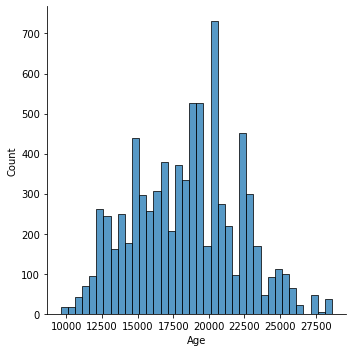

In [9]:
sns.displot(df, x="Age")

### Cleaning

In [10]:
def update(df):
    df_update = df.copy(deep=True)
    df_update.drop(["id"], axis=1, inplace=True)
    df_update["Drug"] = df_update["Drug"].apply(lambda x: 1 if x == "Placebo" else 0)
    df_update["Sex"] = df_update["Sex"].apply(lambda x: 1 if x == "M" else 0)
    df_update["Ascites"] = df_update["Ascites"].apply(lambda x: 1 if x == "N" else 0)
    df_update["Hepatomegaly"] = df_update["Hepatomegaly"].apply(lambda x: 1 if x == "N" else 0)
    df_update["Spiders"] = df_update["Spiders"].apply(lambda x: 1 if x == "N" else 0)
    df_update["Edema"] = df_update["Edema"].apply(lambda x: 1 if x == "N" else 0)
    
    categorical_var = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"]
    for c in categorical_var:
        df_update[c] = df_update[c].astype("category")
    
    if "Status" in df.columns: df_update["Status"] = df_update["Status"].apply(lambda x: 0 if x == "C" else (1 if x == "CL" else 2)).astype("category")
    return df_update

In [11]:
df_update = update(df)

In [12]:
df_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   N_Days         7905 non-null   int64   
 1   Drug           7905 non-null   category
 2   Age            7905 non-null   int64   
 3   Sex            7905 non-null   category
 4   Ascites        7905 non-null   category
 5   Hepatomegaly   7905 non-null   category
 6   Spiders        7905 non-null   category
 7   Edema          7905 non-null   category
 8   Bilirubin      7905 non-null   float64 
 9   Cholesterol    7905 non-null   float64 
 10  Albumin        7905 non-null   float64 
 11  Copper         7905 non-null   float64 
 12  Alk_Phos       7905 non-null   float64 
 13  SGOT           7905 non-null   float64 
 14  Tryglicerides  7905 non-null   float64 
 15  Platelets      7905 non-null   float64 
 16  Prothrombin    7905 non-null   float64 
 17  Stage          7905 non-null   fl

In [13]:
df_update = update(df)
data = np.array(df_update.loc[:, df_update.columns != 'Status'])
target = np.array(df_update['Status'])

In [14]:
data

array([[9.9900e+02, 0.0000e+00, 2.1532e+04, ..., 3.9400e+02, 9.7000e+00,
        3.0000e+00],
       [2.5740e+03, 1.0000e+00, 1.9237e+04, ..., 3.6100e+02, 1.1000e+01,
        3.0000e+00],
       [3.4280e+03, 1.0000e+00, 1.3727e+04, ..., 1.9900e+02, 1.1700e+01,
        4.0000e+00],
       ...,
       [1.5760e+03, 0.0000e+00, 2.5873e+04, ..., 2.0000e+02, 1.2700e+01,
        2.0000e+00],
       [3.5840e+03, 0.0000e+00, 2.2960e+04, ..., 2.2100e+02, 1.0600e+01,
        4.0000e+00],
       [1.9780e+03, 0.0000e+00, 1.9237e+04, ..., 3.3600e+02, 1.0300e+01,
        3.0000e+00]])

In [15]:
df_update

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,0,21532,1,1,1,1,1,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,2
1,2574,1,19237,0,1,1,1,1,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0
2,3428,1,13727,0,1,0,0,0,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,2
3,2576,1,18460,0,1,1,1,1,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0
4,788,1,16658,0,1,0,1,1,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,0,16839,0,1,1,1,1,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,0
7901,1492,1,17031,0,1,0,1,1,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,0
7902,1576,0,25873,0,1,1,0,0,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,2
7903,3584,0,22960,1,1,0,1,1,0.7,248.0,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,2


### Prediction

In [16]:
kf = KFold(n_splits=5, shuffle=True)

In [17]:
def loss(y_true, pred):
    return log_loss(y_true, pred, labels=[0, 1, 2])

In [18]:
prev_loss = 0.4576007377510039

In [19]:
df_test = pd.read_csv("test.csv")
df_test_update = update(df_test)

In [20]:
boosting_rounds = np.arange(40, 100, 5)
for br in boosting_rounds:
    loss_arr = []
    maxd = 2
    lr = 0.3
    for i, (train_index, test_index) in enumerate(kf.split(df)):
        X_train = np.array(df_update.loc[train_index, df_update.columns != 'Status'])
        y_train = np.array(df_update.loc[train_index]['Status'])

        X_test = np.array(df_update.loc[test_index, df_update.columns != 'Status'])
        y_test = np.array(df_update.loc[test_index]['Status'])

        bst = XGBClassifier(n_estimators=br, max_depth=maxd, learning_rate=lr, tree_method='hist', enable_categorical=True, objective='binary:logistic')
        bst.fit(X_train, y_train)

        preds = bst.predict_proba(X_test)

        loss_arr.append(loss(y_test, preds))
    ave_loss = sum(loss_arr)/len(loss_arr)
    print("br = ", br, ", average loss = ", ave_loss)
    
    if ave_loss < prev_loss:
        prev_loss = ave_loss
        preds = bst.predict_proba(np.array(df_test_update))
        
        df_out = pd.DataFrame()
        df_out["id"] = df_test["id"]
        df_out["Status_C"] = preds[:,0].tolist()
        df_out["Status_CL"] = preds[:,1].tolist()
        df_out["Status_D"] = preds[:,2].tolist()
        
        df_out.to_csv("submission_{}_nest-{}_maxdepth-{}_lr-{}.csv".format(ave_loss, br, maxd, lr), index=False)
        print("EXPORTED")

br =  40 , average loss =  0.46452851291954433
br =  45 , average loss =  0.4592959366088755
br =  50 , average loss =  0.45810818489096655
br =  55 , average loss =  0.45530106627952555
EXPORTED
br =  60 , average loss =  0.45510737134116025
EXPORTED
br =  65 , average loss =  0.4541901933263892
EXPORTED
br =  70 , average loss =  0.45140694943466536
EXPORTED
br =  75 , average loss =  0.4522775683805622
br =  80 , average loss =  0.45084510972135183
EXPORTED
br =  85 , average loss =  0.45034190276172303
EXPORTED
br =  90 , average loss =  0.4497287606877604
EXPORTED
br =  95 , average loss =  0.4460268493308635
EXPORTED
